### Random Forests at 14-days leadtime for all regions.

File generated 9/18/2025 for Chapter 4 of Dissertation. 
Modified 12/2/2025 for use in UFS analysis. 

This file utilizes definition statements containing RF architecture to create three separate RF models, each for a designated forecast region. 

Forecast leadtime can be changed as needed. 

In [1]:
##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

import random
from random import seed
from random import randint
from random import sample

import seaborn as sns # statistical data visualization
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel

import keras
import shap

2025-12-05 13:51:45.716282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 13:51:45.772815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 13:51:45.772853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 13:51:45.773904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-05 13:51:45.785782: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#import definitions 
from SkillStats_MOD import BSS, RAS, PAS

from RF_archMOD import rf_featselect,rf_90thpercentile

I am going to do a modified version of the architecture def here because I have to change the dataset structure. 

Start with bringing in the old data for training/validation. 

In [3]:
#load OG input data, it is max/min standardized, NaNs removed
#stratospheric polar vortex ellipse diagnostics from Fernandez et al 2025 (in review)
infile = open("./old_data/nolag_extendedanom_input.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

nolag_input.shape 

(62, 149, 8)

The input data stays the same regardless of forecast region. 

The original array starts on October 19th. The shift send this forward to November 2nd. 

In [4]:
idx = 135 #129 for 20, 119 for 30.
inp1 = np.empty((52,idx,7)) #cnew input array, 14 day lag. 
shift = 14

##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:52,shift:,0] ##wind
inp1[:,:,1] = nolag_input[:52,shift:,1] ##ratio
inp1[:,:,2] = nolag_input[:52,shift:,2] ##latitude
inp1[:,:,3] = nolag_input[:52,shift:,3] ##longitude
inp1[:,:,4] = nolag_input[:52,shift:,4] ##size
inp1[:,:,5] = nolag_input[:52,shift:,5] ##ephi
inp1[:,:,6] = nolag_input[:52,shift:,6] ##gph

inp = inp1.reshape(52*idx,7)

#convert to pandas dataframe
input1 = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph']
input1.columns = col_names

In [5]:
##load in desired TESTING dataset... varies based on prototype.
infile = open("./new_data/input_ERA5.p", 'rb') 
testing_input = pickle.load(infile)
infile.close()

inp = testing_input.reshape(56*18,7)

#convert to pandas dataframe
input2 = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph']
input2.columns = col_names

### Begin RF Feature selection test. 

In [6]:
def feat_imp_plot(important,input1,files):
    imp = np.nanmean(important, axis = 0)
    imp.shape
    
    #plot features by relative importance
    indices = np.argsort(imp)[::-1]  #sort by importance
    c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]
    
    plt.figure(figsize=(9, 6))
    plt.title(f'Average Feature Importances Across 100 CVs, {str(files)}',fontsize =18)
    plt.barh(range(input1.shape[1]), imp[indices], align="center", color = c)
    plt.yticks(range(input1.shape[1]), input1.columns[indices],fontsize =14)
    plt.xticks(fontsize =14)
    plt.xlabel("Relative Importance",fontsize =16)
    plt.gca().invert_yaxis()
    plt.savefig(f'./images/FeatureImportance_{str(files)}.png',bbox_inches = 'tight')

In [7]:
#number of cross validations
n = 100

regions = ['eur','nova','seus']

Working on Europe_ERA5 ...
Begin CV ...
###################################################
Accuracy, Validation: 57.89%
Accuracy, Training: 63.17%
Accuracy, Testing: 60.62%
_____________________________________
Working on Europe_Prototype5 ...
Begin CV ...
###################################################
Accuracy, Validation: 57.65%
Accuracy, Training: 63.17%
Accuracy, Testing: 61.66%
_____________________________________
Working on Europe_Prototype6 ...
Begin CV ...
###################################################
Accuracy, Validation: 56.99%
Accuracy, Training: 63.12%
Accuracy, Testing: 56.60%
_____________________________________
Working on Europe_Prototype7 ...
Begin CV ...
###################################################
Accuracy, Validation: 57.53%
Accuracy, Training: 63.13%
Accuracy, Testing: 58.26%
_____________________________________
Working on Europe_Prototype8 ...
Begin CV ...
###################################################
Accuracy, Validation: 57.65%
Accurac

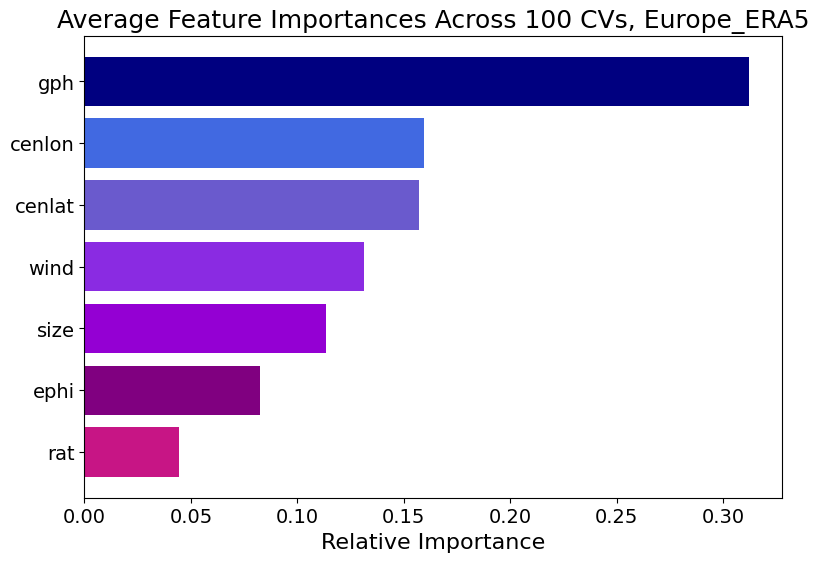

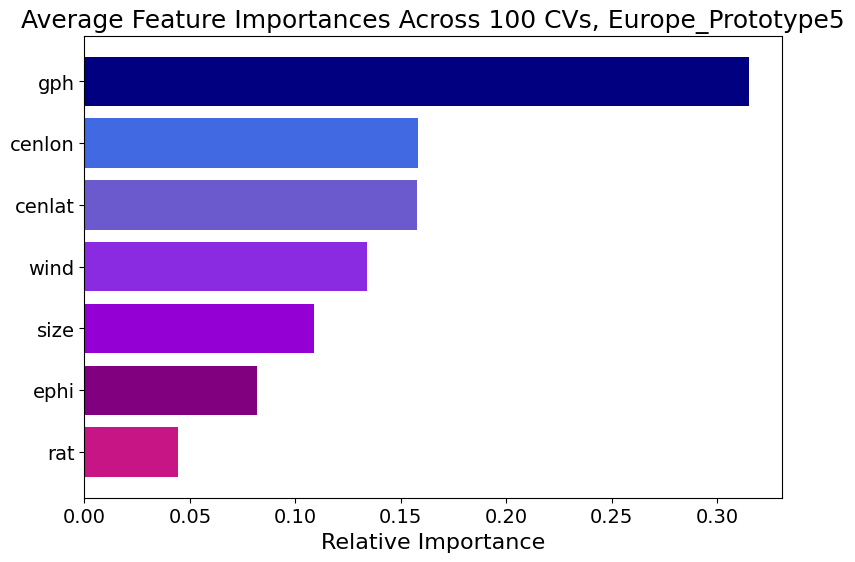

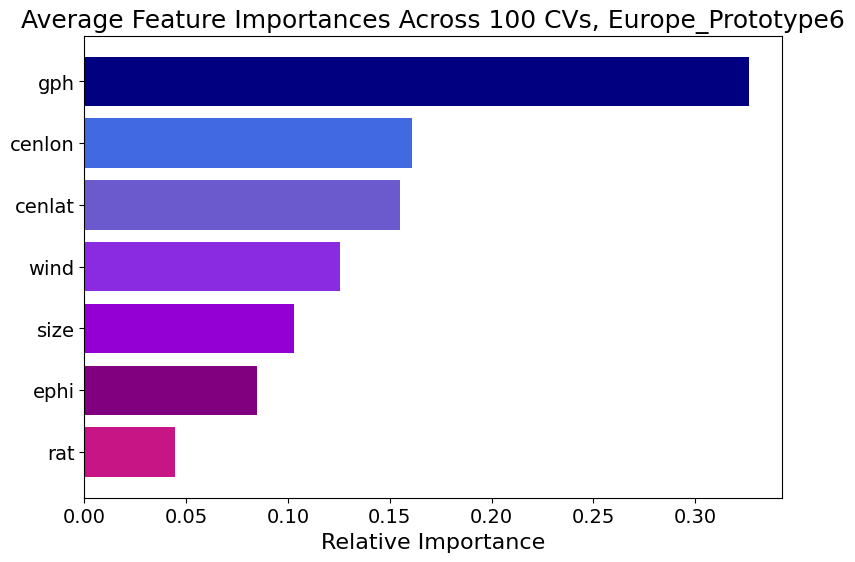

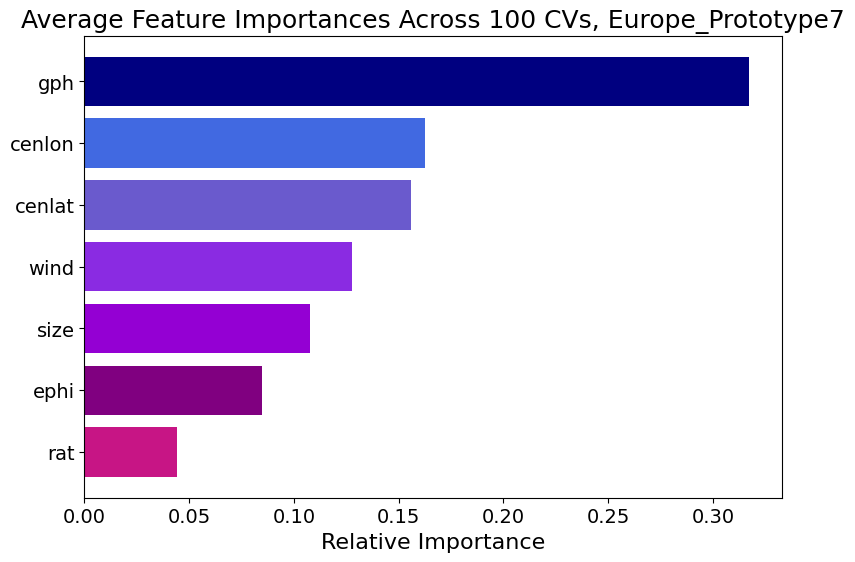

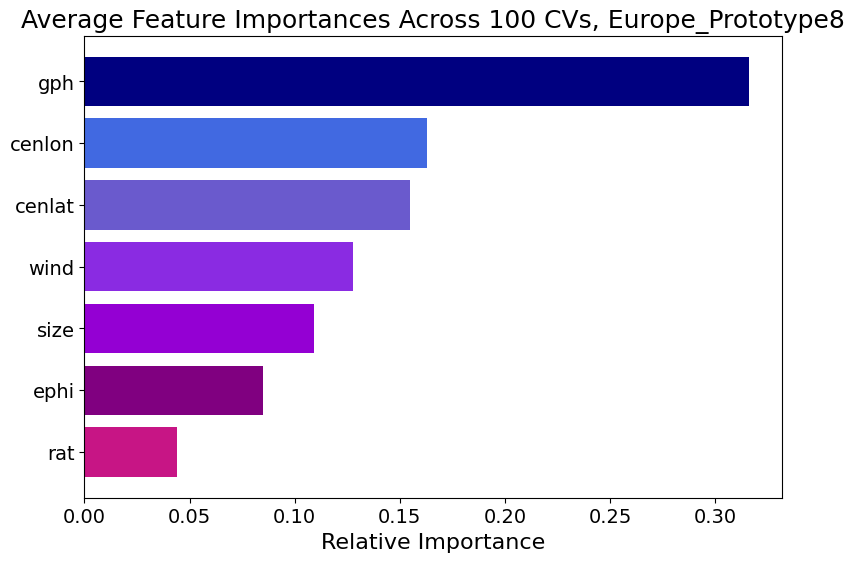

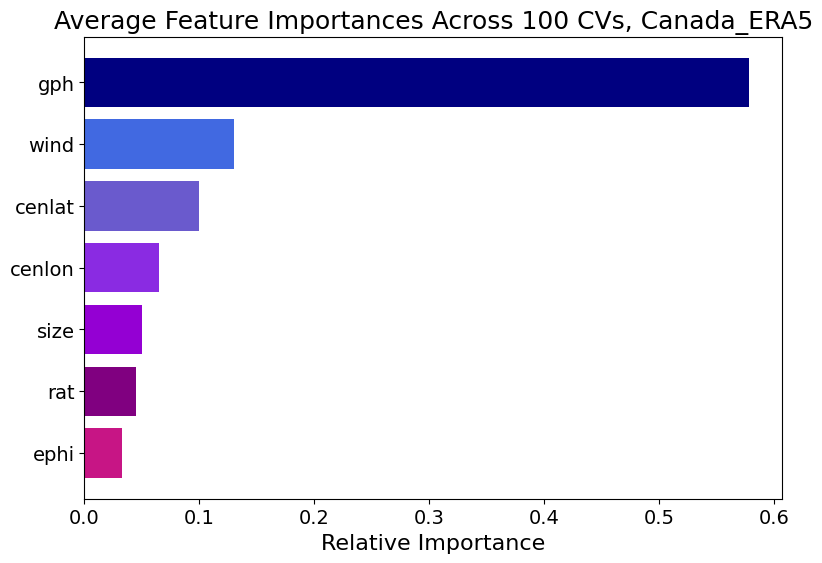

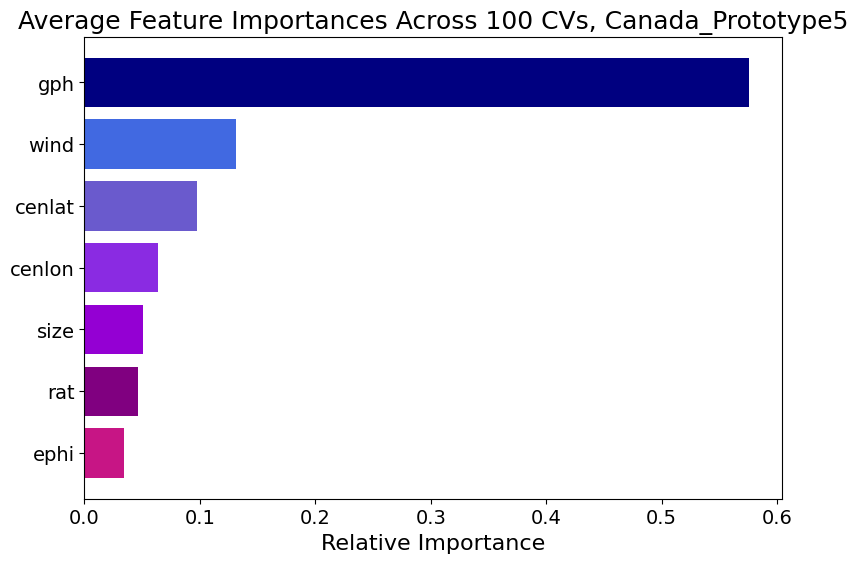

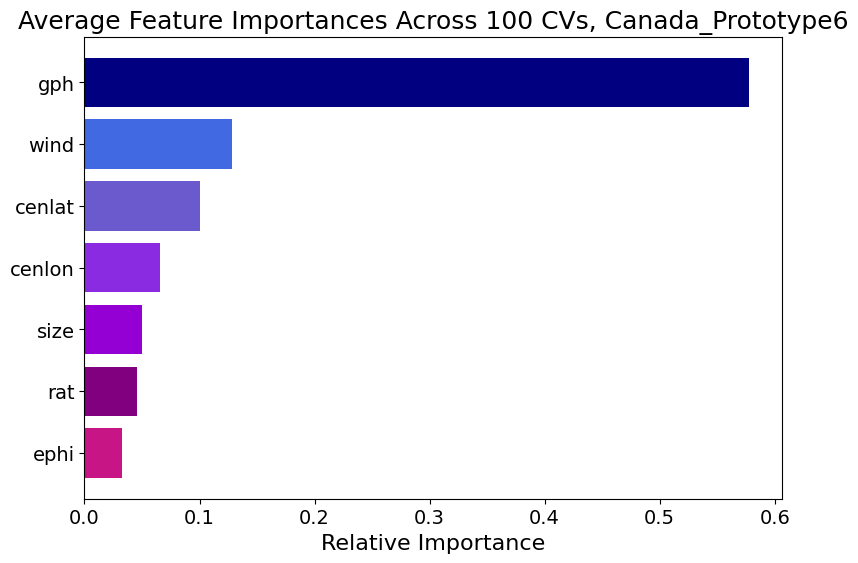

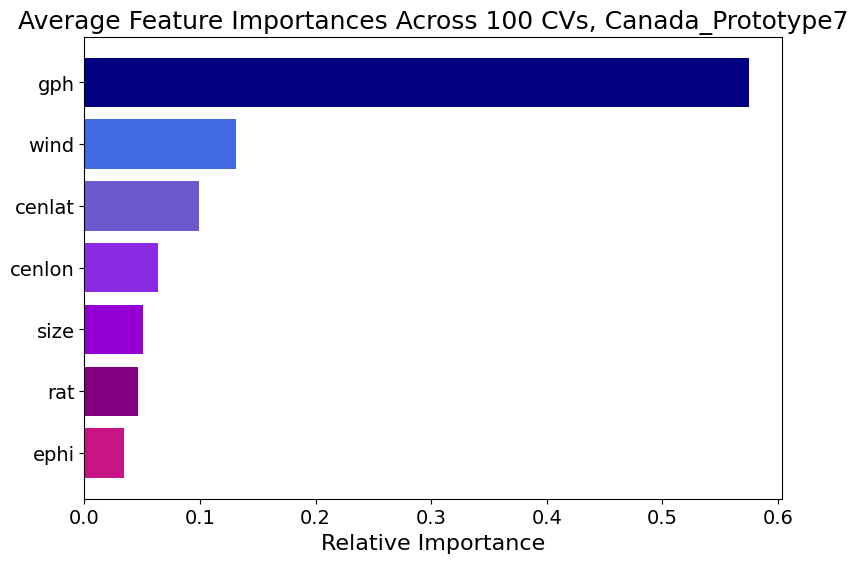

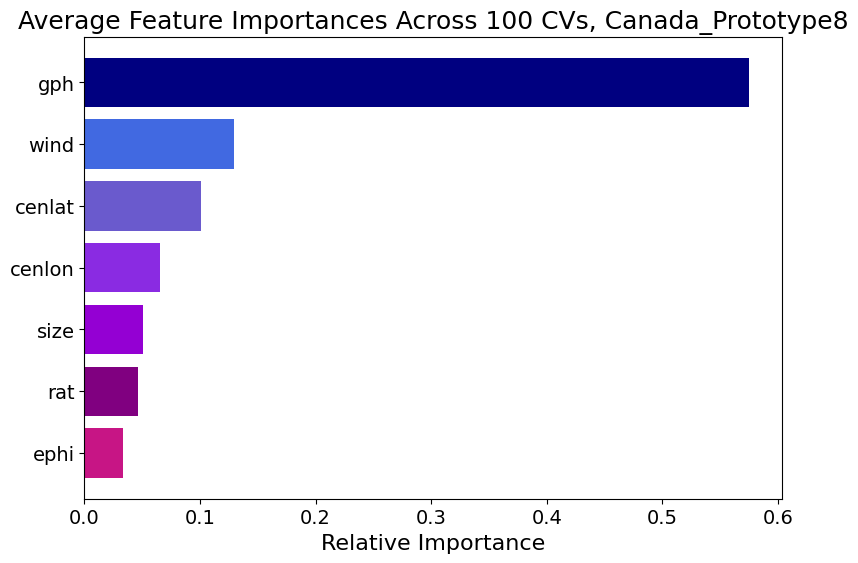

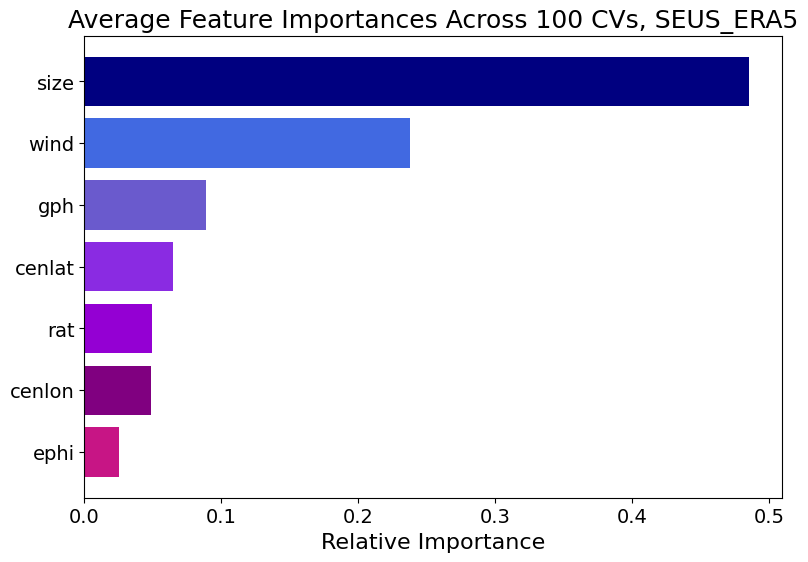

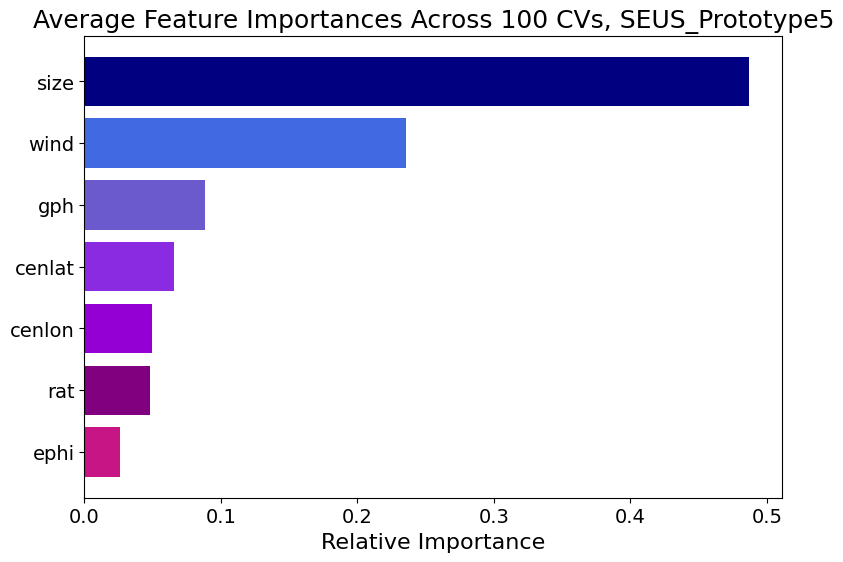

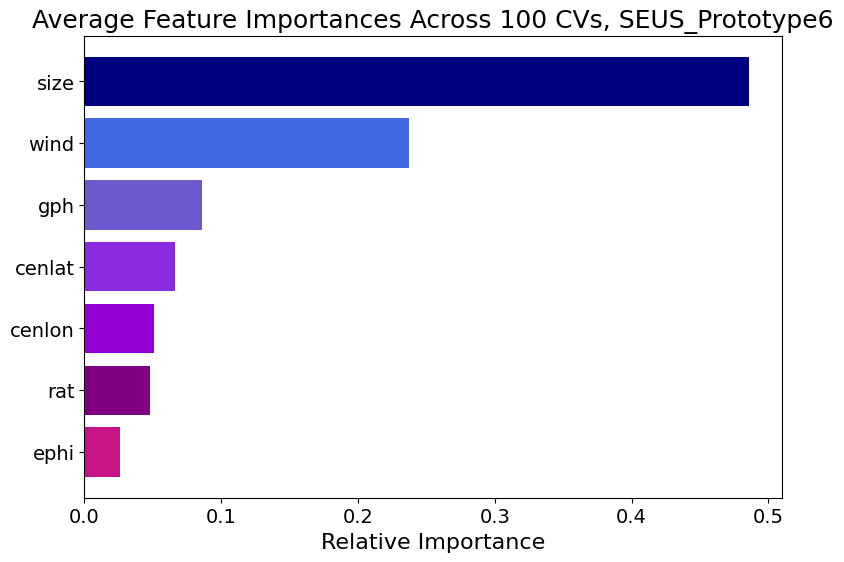

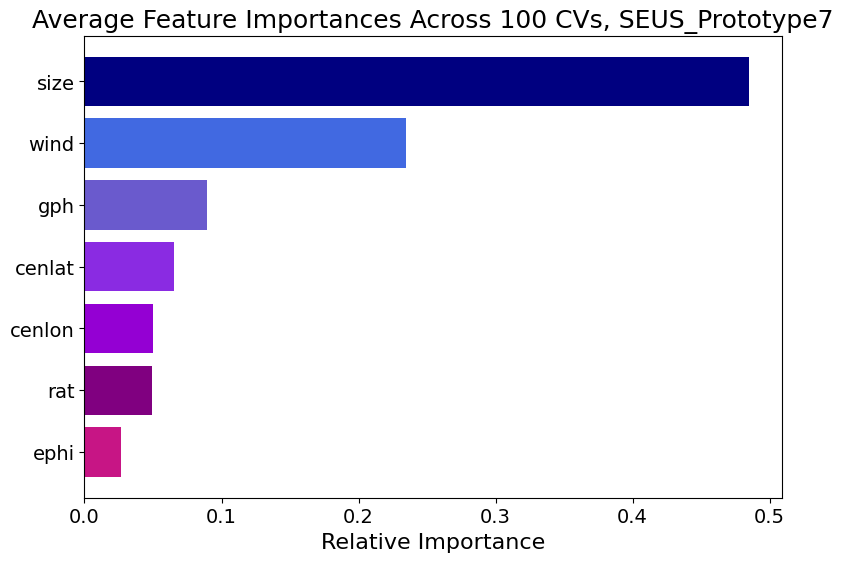

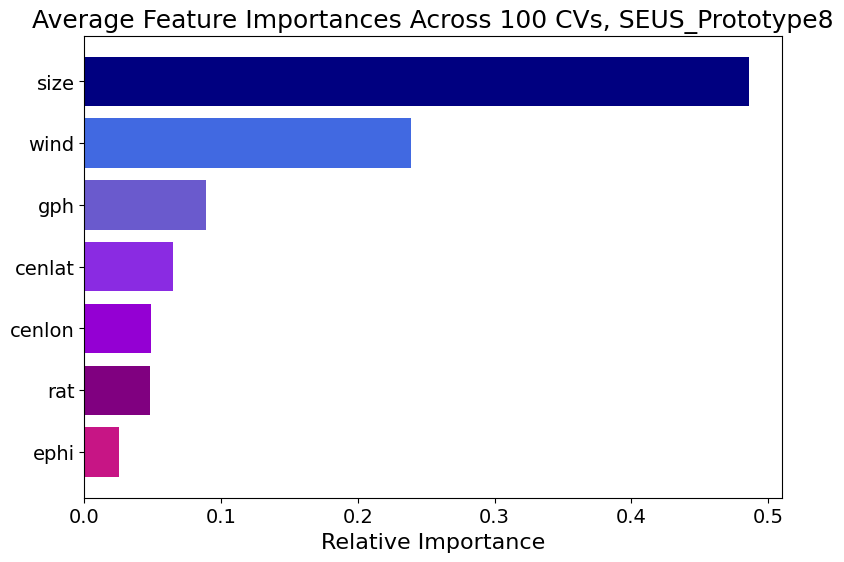

In [8]:
##Loop through regions and files to do feature selection.
for i in range(len(regions)):
    ##EUROPE
    if regions[i] == 'eur':
        files = ['Europe_ERA5','Europe_Prototype5','Europe_Prototype6','Europe_Prototype7','Europe_Prototype8']
        for j in range(len(files)):
            print(f'Working on {str(files[j])} ...')
            eur_important = rf_featselect(n,shift,idx,input1,input2,regions[i],files[j])
            feat_imp_plot(eur_important,input1,files[j])
            print('_____________________________________')
    ##CANADA
    if regions[i] == 'nova':
        files = ['Canada_ERA5','Canada_Prototype5','Canada_Prototype6','Canada_Prototype7','Canada_Prototype8']
        for j in range(len(files)):
            print(f'Working on {str(files[j])} ...')
            can_important = rf_featselect(n,shift,idx,input1,input2,regions[i],files[j])
            feat_imp_plot(can_important,input1,files[j])
            print('_____________________________________')
    ##SEUS
    if regions[i] == 'seus':
        files = ['SEUS_ERA5','SEUS_Prototype5','SEUS_Prototype6','SEUS_Prototype7','SEUS_Prototype8']
        for j in range(len(files)):
            print(f'Working on {str(files[j])} ...')
            seus_important = rf_featselect(n,shift,idx,input1,input2,regions[i],files[j])
            feat_imp_plot(seus_important,input1,files[j])
            print('_____________________________________')

## Second RF run post feature selection

### Europe

In [9]:
##Loop through regions and files to do feature selection.
files = ['Europe_ERA5','Europe_Prototype5','Europe_Prototype6','Europe_Prototype7','Europe_Prototype8']
eur_input1 = input1[["wind","cenlon","cenlat","gph"]]
eur_input2 = input2[["wind","cenlon","cenlat","gph"]]

for j in range(len(files)):
    print(f'Working on {str(files[j])} ...')
    
    ##CONSTANT ERA5 OUTPUT
    infile = open(f'./new_data/2classtemps_Europe_ERA5.p',"rb",)
    ERA5_temp = pickle.load(infile) 
    infile.close()

    eur_test90, eur_fulltest, eur_shap_obj, eur_posXtest, eur_FposXtest, eur_negXtest, eur_FnegXtest, acc_reg2_test, acc_reg3_test, acc_reg4_test = rf_90thpercentile(n,shift, idx, eur_input1, eur_input2, ERA5_temp, 'eur', files[j])
    #____________________________________________________#
    #plot SHAP
    plt.title(f'SHAP Values for Negative Europe Temp Anomalies, {str(files[j])}',fontsize =14, y = 1.05)
    ax = shap.plots.beeswarm(eur_shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
    plt.tight_layout()
    plt.savefig(f'./images/SHAP_{str(files[j])}.png')
    plt.close()
    #____________________________________________________#
    #plot ACC
    bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
    ##bin the testing 90th percentile accuracy data
    counts90, edges90 = np.histogram(eur_test90, bins=bins)
    countsfull, edgesfull = np.histogram(eur_fulltest, bins=bins)
    counts_era5, edges_era5= np.histogram(acc_reg3_test, bins=bins) ##relative to ERA5 truth
    #plot the full dataset
    #offset = 0.02  # Adjust this value if needed for better visibility
    plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
            edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
    
    #plot the 90th percentile
    plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
            edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
    
    #plot the ERA-5 comparison
    plt.bar(edges_era5[:-1], counts_era5, width=np.diff(edges_era5), 
            edgecolor='black', alpha=0.5, label='Predictions vs. ERA-5 Truth', align='edge', color = 'indigo')
    
    plt.xlabel('Accuracy',fontsize =14)
    plt.ylabel('Number of Models',fontsize =14)
    plt.legend()
    plt.title(f'Testing ACCs for 100 CVs, {str(files[j])}',fontsize =12)
    plt.tight_layout()
    plt.savefig(f'./images/ACC_{str(files[j])}.png')
    plt.close()
    print('_____________________________________')
    #____________________________________________________#
    ##export out files to make the next few plots w/o normalization
    pickle.dump(eur_posXtest, open(f'./index/pos_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_FposXtest, open(f'./index/Fpos_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_negXtest, open(f'./index/neg_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_FnegXtest, open(f'./index/Fneg_{str(files[j])}.p', 'wb'))

Working on Europe_ERA5 ...
 
Creating lists ...
 
Establishing RF hyperparams ...
 
Begin RF CV.
 
END CV.
 
 
###################################################
Accuracy, Validation: 58.05%
Accuracy, Training: 61.95%
Accuracy, Testing: 58.77%
_____________________________________________________________________
Brier Skill Score (Train): 0.0701
Brier Skill Score (Test): 0.0426
Brier Skill Score (Validation): 0.0247
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Train): 0.7482
Recall Accuracy Score (Test): 0.7754
Recall AccuracyScore (Validation): 0.7234
Precision Accuracy Score (Train): 0.6101
Precision Accuracy Score (Test): 0.5620
Precision AccuracyScore (Validation): 0.5755
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Train): 0.4792
Recall Accuracy Score (Test): 0.4029
Recall AccuracyScore (Validation): 0.4301

### Canada

In [10]:
##Loop through regions and files to do feature selection.
files = ['Canada_ERA5','Canada_Prototype5','Canada_Prototype6','Canada_Prototype7','Canada_Prototype8']
eur_input1 = input1[["wind","cenlon","cenlat","gph"]]
eur_input2 = input2[["wind","cenlon","cenlat","gph"]]

for j in range(len(files)):
    print(f'Working on {str(files[j])} ...')

    ##CONSTANT ERA5 OUTPUT
    infile = open(f'./new_data/2classtemps_Canada_ERA5.p',"rb",)
    ERA5_temp = pickle.load(infile) 
    infile.close()
    
    eur_test90, eur_fulltest, eur_shap_obj, eur_posXtest, eur_FposXtest, eur_negXtest, eur_FnegXtest, acc_reg2_test, acc_reg3_test, acc_reg4_test = rf_90thpercentile(n,shift, idx, eur_input1, eur_input2, ERA5_temp, 'nova',files[j])
    #____________________________________________________#
    #plot SHAP
    plt.title(f'SHAP Values for Negative Canadian Temp Anomalies, {str(files[j])}',fontsize =14, y = 1.05)
    ax = shap.plots.beeswarm(eur_shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
    plt.tight_layout()
    plt.savefig(f'./images/SHAP_{str(files[j])}.png')
    plt.close()
    #____________________________________________________#
    #plot ACC
    bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
    ##bin the testing 90th percentile accuracy data
    counts90, edges90 = np.histogram(eur_test90, bins=bins)
    countsfull, edgesfull = np.histogram(eur_fulltest, bins=bins)
    counts_era5, edges_era5= np.histogram(acc_reg3_test, bins=bins) ##relative to ERA5 truth
    #plot the full dataset
    #offset = 0.02  # Adjust this value if needed for better visibility
    plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
            edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
    
    #plot the 90th percentile
    plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
            edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
    
    #plot the ERA-5 comparison
    plt.bar(edges_era5[:-1], counts_era5, width=np.diff(edges_era5), 
            edgecolor='black', alpha=0.5, label='Predictions vs. ERA-5 Truth', align='edge', color = 'indigo')
    
    plt.xlabel('Accuracy',fontsize =14)
    plt.ylabel('Number of Models',fontsize =14)
    plt.legend()
    plt.title(f'Testing ACCs for 100 CVs, {str(files[j])}',fontsize =12)
    plt.tight_layout()
    plt.savefig(f'./images/ACC_{str(files[j])}.png')
    plt.close()
    print('_____________________________________')
    #____________________________________________________#
    ##export out files to make the next few plots w/o normalization
    pickle.dump(eur_posXtest, open(f'./index/pos_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_FposXtest, open(f'./index/Fpos_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_negXtest, open(f'./index/neg_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_FnegXtest, open(f'./index/Fneg_{str(files[j])}.p', 'wb'))

Working on Canada_ERA5 ...
 
Creating lists ...
 
Establishing RF hyperparams ...
 
Begin RF CV.
 
END CV.
 
 
###################################################
Accuracy, Validation: 70.38%
Accuracy, Training: 71.96%
Accuracy, Testing: 75.53%
_____________________________________________________________________
Brier Skill Score (Train): 0.2194
Brier Skill Score (Test): 0.2057
Brier Skill Score (Validation): 0.1785
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Train): 0.8748
Recall Accuracy Score (Test): 0.8772
Recall AccuracyScore (Validation): 0.8614
Precision Accuracy Score (Train): 0.7047
Precision Accuracy Score (Test): 0.7542
Precision AccuracyScore (Validation): 0.6979
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Train): 0.5138
Recall Accuracy Score (Test): 0.5739
Recall AccuracyScore (Validation): 0.4891

### SEUS

In [11]:
##Loop through regions and files to do feature selection.
files = ['SEUS_ERA5','SEUS_Prototype5','SEUS_Prototype6','SEUS_Prototype7','SEUS_Prototype8']
eur_input1 = input1[["wind","size","cenlat","gph"]]
eur_input2 = input2[["wind","size","cenlat","gph"]]

for j in range(len(files)):
    print(f'Working on {str(files[j])} ...')

    ##CONSTANT ERA5 OUTPUT
    infile = open(f'./new_data/2classtemps_SEUS_ERA5.p',"rb",)
    ERA5_temp = pickle.load(infile) 
    infile.close()
    
    eur_test90, eur_fulltest, eur_shap_obj, eur_posXtest, eur_FposXtest, eur_negXtest, eur_FnegXtest, acc_reg2_test, acc_reg3_test, acc_reg4_test = rf_90thpercentile(n,shift, idx, eur_input1, eur_input2, ERA5_temp, 'seus', files[j])
    #____________________________________________________#
    #plot SHAP
    plt.title(f'SHAP Values for SEUS Temp Anomalies, {str(files[j])}',fontsize =14, y = 1.05)
    ax = shap.plots.beeswarm(eur_shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
    plt.tight_layout()
    plt.savefig(f'./images/SHAP_{str(files[j])}.png')
    plt.close()
    #____________________________________________________#
    #plot ACC
    bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
    ##bin the testing 90th percentile accuracy data
    counts90, edges90 = np.histogram(eur_test90, bins=bins)
    countsfull, edgesfull = np.histogram(eur_fulltest, bins=bins)
    counts_era5, edges_era5= np.histogram(acc_reg3_test, bins=bins) ##relative to ERA5 truth
    #plot the full dataset
    #offset = 0.02  # Adjust this value if needed for better visibility
    plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
            edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
    
    #plot the 90th percentile
    plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
            edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
    
    #plot the ERA-5 comparison
    plt.bar(edges_era5[:-1], counts_era5, width=np.diff(edges_era5), 
            edgecolor='black', alpha=0.5, label='Predictions vs. ERA-5 Truth', align='edge', color = 'indigo')
    
    plt.xlabel('Accuracy',fontsize =14)
    plt.ylabel('Number of Models',fontsize =14)
    plt.legend()
    plt.title(f'Testing ACCs for 100 CVs, {str(files[j])}',fontsize =12)
    plt.tight_layout()
    plt.savefig(f'./images/ACC_{str(files[j])}.png')
    plt.close()
    print('_____________________________________')
    #____________________________________________________#
     ##export out files to make the next few plots w/o normalization
    pickle.dump(eur_posXtest, open(f'./index/pos_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_FposXtest, open(f'./index/Fpos_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_negXtest, open(f'./index/neg_{str(files[j])}.p', 'wb'))
    pickle.dump(eur_FnegXtest, open(f'./index/Fneg_{str(files[j])}.p', 'wb'))

Working on SEUS_ERA5 ...
 
Creating lists ...
 
Establishing RF hyperparams ...
 
Begin RF CV.
 
END CV.
 
 
###################################################
Accuracy, Validation: 61.45%
Accuracy, Training: 63.19%
Accuracy, Testing: 60.78%
_____________________________________________________________________
Brier Skill Score (Train): 0.0981
Brier Skill Score (Test): 0.0439
Brier Skill Score (Validation): 0.0658
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Train): 0.7076
Recall Accuracy Score (Test): 0.7257
Recall AccuracyScore (Validation): 0.6938
Precision Accuracy Score (Train): 0.6267
Precision Accuracy Score (Test): 0.6318
Precision AccuracyScore (Validation): 0.6118
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Train): 0.5514
Recall Accuracy Score (Test): 0.4561
Recall AccuracyScore (Validation): 0.5297
P